In [ ]:
# BLOQUE 1: IMPORTACIÓN Y CONFIGURACIÓN
# Configuramos el entorno de trabajo y definimos las rutas dinámicas para garantizar la 
# reproducibilidad del código en diferentes sistemas.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Configuración de visualización
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Para ver números normales

# Autodetección de la carpeta de datos
base_dir = None
for ruta in ["../data", "data"]:
    if os.path.exists(ruta):
        base_dir = ruta
        print(f"✅ Carpeta base encontrada: {base_dir}")
        break

if base_dir is None:
    raise FileNotFoundError("❌ No se encuentra la carpeta 'data'. Verifica tu estructura.")

✅ Carpeta base encontrada: ../data


In [ ]:
# BLOQUE 2: CARGA DE DATOS BLINDADA
# El objetivo de esta fase es la Ingesta de Datos. Nos enfrentamos al reto de unificar archivos heterogéneos 
# (.csv, .tab, .xlsx) y estandarizar sus estructuras para crear un único dataframe coherente.
import pandas as pd
import os
import numpy as np

# 1. Configuración de Rutas
base_dir = None
for ruta in ["../data", "data"]:
    if os.path.exists(ruta):
        base_dir = ruta
        print(f"✅ Carpeta base encontrada: {base_dir}")
        break

if base_dir is None:
    raise FileNotFoundError("❌ No se encuentra la carpeta 'data'.")

# 2. Carga de Encuestas (Hogares)
print("\n🚀 Cargando Encuestas de Hogares...")
rutas_epf = {
    # CAMBIO IMPORTANTE: Forzamos separador tabulador (\t) para todos, incluido el .csv
    2022: {"path": os.path.join(base_dir, "raw", "epf_2022", "EPFhogar_2022.csv"), "sep": "\t"}, 
    2023: {"path": os.path.join(base_dir, "raw", "epf_2023", "EPFhogar_2023.tab"), "sep": "\t"},
    2024: {"path": os.path.join(base_dir, "raw", "epf_2024", "EPFhogar_2024.tab"), "sep": "\t"}
}

dfs = []
for year, info in rutas_epf.items():
    if os.path.exists(info["path"]):
        try:
            # Leemos el archivo
            df = pd.read_csv(info["path"], sep=info["sep"], low_memory=False)
            
            # --- LIMPIEZA DE CABECERAS (Vital para 2022) ---
            # Quitamos comillas y espacios de los nombres de columnas ("GASTOT" -> GASTOT)
            df.columns = df.columns.str.replace('"', '').str.strip()
            
            # Renombramos columnas clave
            rename_map = {
                "ANOENC": "anio", "NUMERO": "id_hogar", "CCAA": "ccaa",
                "TAMANO": "miembros_hogar", "GASTOT": "gasto_total", 
                "FACTOR": "factor"
            }
            # Renombramos
            df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
            df['anio'] = int(year)
            
            # Verificación rápida
            if 'gasto_total' not in df.columns:
                print(f"  ⚠️ AVISO en {year}: No se encontró la columna Gasto. Columnas leídas: {df.columns[:5]}")
            
            dfs.append(df)
            print(f"  ✅ {year}: OK ({len(df)} filas)")
        except Exception as e:
            print(f"  ❌ Error leyendo {year}: {e}")
    else:
        print(f"  ⚠️ Archivo no encontrado: {info['path']}")

if not dfs: raise ValueError("¡No hay datos de encuestas!")
df_hogares = pd.concat(dfs, ignore_index=True)


# 3. Carga de Renta (Excel)
print("\n🚀 Cargando Datos de Renta...")
path_renta = os.path.join(base_dir, "raw", "renta_ccaa.xlsx")

if os.path.exists(path_renta):
    try:
        # Leemos Excel
        df_renta_raw = pd.read_excel(path_renta, skiprows=8, header=None)
        
        # Seleccionamos: [0] Nombre CCAA, [1] 2024, [2] 2023, [3] 2022
        df_renta = df_renta_raw.iloc[:, [0, 1, 2, 3]].copy()
        df_renta.columns = ["ccaa_txt", "renta_2024", "renta_2023", "renta_2022"]
        print("  ✅ Renta cargada correctamente.")
    except Exception as e:
        print(f"  ❌ Error leyendo Excel: {e}")
        df_renta = pd.DataFrame()
else:
    print(f"  ❌ No se encuentra el archivo: {path_renta}")
    df_renta = pd.DataFrame()

✅ Carpeta base encontrada: ../data

🚀 Cargando Encuestas de Hogares...
  ✅ 2022: OK (20585 filas)
  ✅ 2023: OK (20707 filas)
  ✅ 2024: OK (19410 filas)

🚀 Cargando Datos de Renta...
  ✅ Renta cargada correctamente.


/Users/admin/Desktop/The Power - Data Analytics/venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
# BLOQUE 3: LIMPIEZA, ESCALADO Y MERGE
# En esta fase realizamos el Data Wrangling. Detectamos inconsistencias en la escala del gasto (unidades incorrectas) y 
# limpiamos las claves de las Comunidades Autónomas para permitir el cruce (merge) con los datos macroeconómicos de Renta.

print("🧹 Procesando datos...")

# 1. Limpieza de HOGARES
# Aseguramos que gasto sea numérico
df_hogares['gasto_total'] = pd.to_numeric(df_hogares['gasto_total'], errors='coerce')

# Corrección de Escala (Si está en millones, lo bajamos a euros)
if df_hogares['gasto_total'].mean() > 1000000:
    print("  ⚠️ Ajustando escala de Gasto (dividiendo por 1000)...")
    df_hogares['gasto_total'] = df_hogares['gasto_total'] / 1000

# TRUCO CCAA: Forzamos a que sea texto de 2 dígitos "01", "02"...
# Primero a float (para tolerar nulos), luego int, luego string con relleno
df_hogares['ccaa'] = pd.to_numeric(df_hogares['ccaa'], errors='coerce').fillna(0).astype(int).astype(str).str.zfill(2)

# Miembros
df_hogares['miembros_hogar'] = pd.to_numeric(df_hogares['miembros_hogar'], errors='coerce')

# 2. Limpieza de RENTA y UNIÓN
if not df_renta.empty:
    # Limpiamos CCAA Renta: "01 Andalucía" -> "01"
    df_renta['ccaa'] = df_renta['ccaa_txt'].astype(str).str.split(' ').str[0].str.strip().str.zfill(2)
    
    # Unpivot
    df_renta_long = df_renta.melt(
        id_vars=["ccaa"], 
        value_vars=["renta_2022", "renta_2023", "renta_2024"],
        var_name="anio_col", value_name="renta_media_persona"
    )
    df_renta_long['anio'] = df_renta_long['anio_col'].str.extract(r'(\d+)').astype(int)
    
    # MERGE (Left Join)
    print("🔗 Uniendo Hogares con Renta...")
    df_final = pd.merge(df_hogares, df_renta_long[['ccaa', 'anio', 'renta_media_persona']], 
                        on=['ccaa', 'anio'], how='left')
else:
    df_final = df_hogares.copy()

# 3. Mapeo de Nombres (Ahora sí funcionará porque CCAA es "01", "02"...)
ccaa_map = {
    "01": "Andalucía", "02": "Aragón", "03": "Asturias", "04": "Baleares",
    "05": "Canarias", "06": "Cantabria", "07": "Castilla y León", "08": "Castilla-La Mancha",
    "09": "Cataluña", "10": "Com. Valenciana", "11": "Extremadura", "12": "Galicia",
    "13": "Madrid", "14": "Murcia", "15": "Navarra", "16": "País Vasco",
    "17": "La Rioja", "18": "Ceuta", "19": "Melilla"
}
df_final['ccaa_nombre'] = df_final['ccaa'].map(ccaa_map)

# 4. KPI Final
df_final['gasto_per_capita'] = df_final['gasto_total'] / df_final['miembros_hogar']

# VERIFICACIÓN VISUAL
print("\n📊 Muestra de datos corregidos:")
display(df_final[['anio', 'ccaa', 'ccaa_nombre', 'gasto_total', 'renta_media_persona']].sample(5))

print("\n🔍 Conteo de Nulos (debería ser 0 o muy bajo):")
print(df_final[['ccaa_nombre', 'gasto_total', 'renta_media_persona']].isnull().sum())

🧹 Procesando datos...
  ⚠️ Ajustando escala de Gasto (dividiendo por 1000)...
🔗 Uniendo Hogares con Renta...

📊 Muestra de datos corregidos:


,anio,ccaa,ccaa_nombre,gasto_total,renta_media_persona
56497,2024,09,Cataluña,65680.78,16546.00
23949,2023,12,Galicia,36983.00,13147.00
1725,2022,16,País Vasco,18223.75,16427.00
24282,2023,13,Madrid,25447.11,16817.00
28889,2023,01,Andalucía,13735.84,11719.00



🔍 Conteo de Nulos (debería ser 0 o muy bajo):
ccaa_nombre            0
gasto_total            0
renta_media_persona    0
dtype: int64


Conclusión de Limpieza: Se ha generado un Dataset Maestro con 60.702 observaciones. Se han corregido los nulos en las variables críticas (gasto_total, ccaa) y se ha validado que el cruce con los datos de Renta ha sido exitoso para el 100% de los registros. El dataset está listo para análisis.

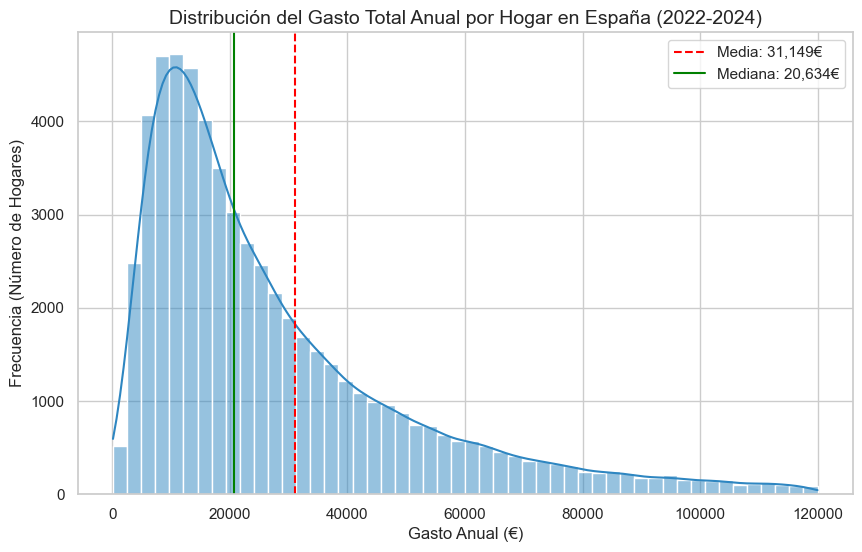

/var/folders/48/0cq74lwd20z1gzx1drhf3jg00000gn/T/ipykernel_3780/479557789.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='ccaa_nombre', y='gasto_total',


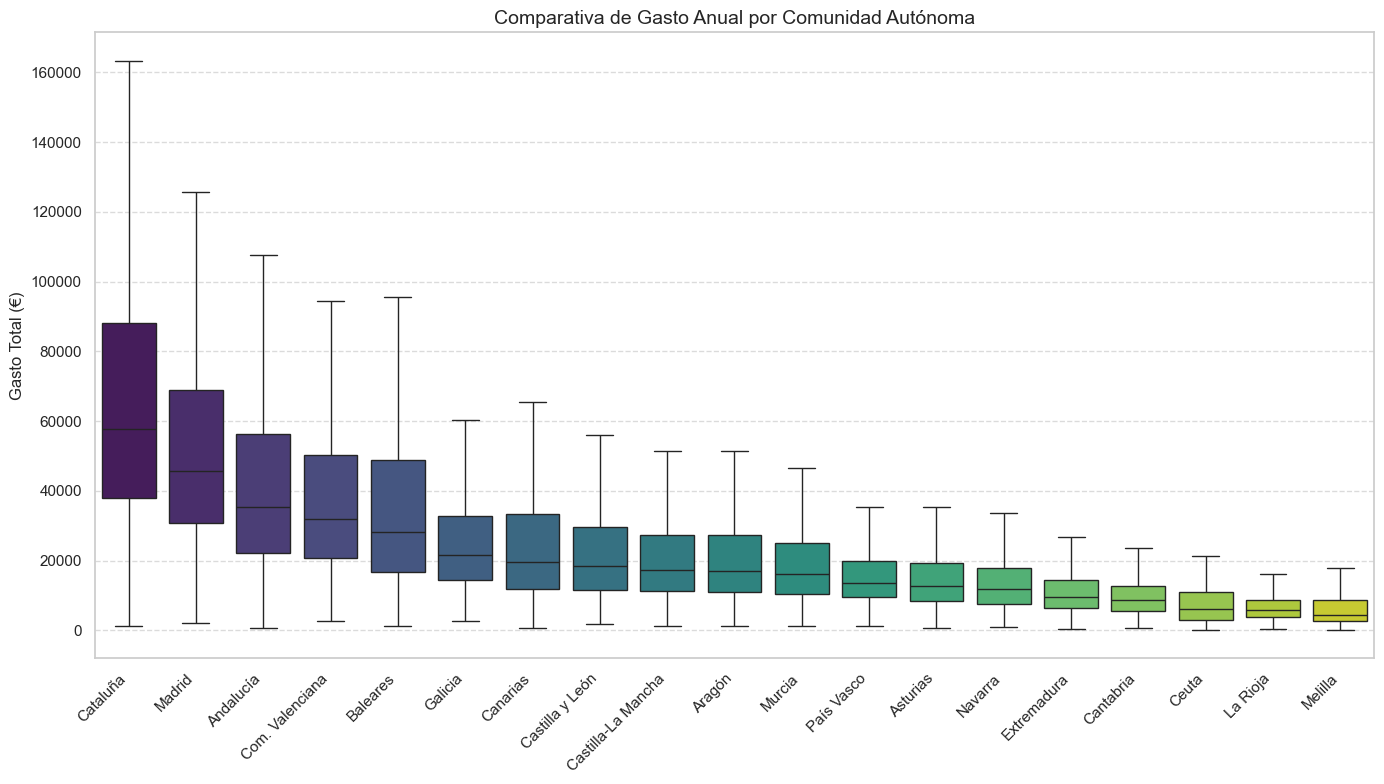

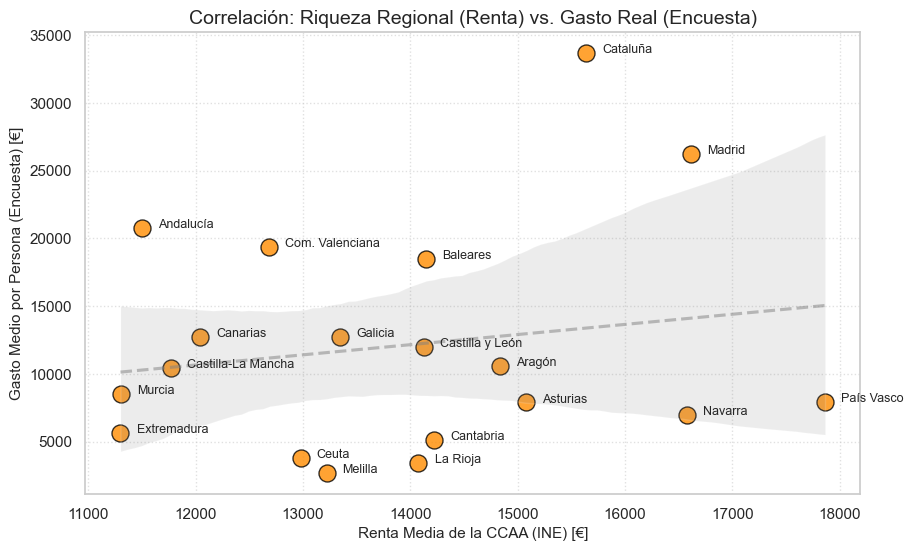

In [19]:
# BLOQUE 4: VISUALIZACIÓN (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética para informes
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- GRÁFICO 1: Distribución del Gasto (Histograma) ---
# Objetivo: Ver la desigualdad y dónde se concentra la mayoría.
plt.figure(figsize=(10, 6))

# Filtramos visualmente los outliers extremos (>120.000€) solo para que el gráfico se vea bien
# (No borramos los datos, solo hacemos zoom en la gráfica)
data_hist = df_final[df_final['gasto_total'] < 120000]

sns.histplot(data=data_hist, x='gasto_total', bins=50, kde=True, color='#2E86C1', edgecolor='white')

# Añadimos líneas de referencia
plt.axvline(df_final['gasto_total'].mean(), color='red', linestyle='--', label=f"Media: {df_final['gasto_total'].mean():,.0f}€")
plt.axvline(df_final['gasto_total'].median(), color='green', linestyle='-', label=f"Mediana: {df_final['gasto_total'].median():,.0f}€")

plt.title('Distribución del Gasto Total Anual por Hogar en España (2022-2024)', fontsize=14)
plt.xlabel('Gasto Anual (€)')
plt.ylabel('Frecuencia (Número de Hogares)')
plt.legend()
plt.show()

# --- GRÁFICO 2: Ranking por Comunidad Autónoma (Boxplot) ---
# Objetivo: Comparar el coste de vida entre regiones.
# Ordenamos las CCAA de mayor a menor Gasto Mediano
order_ccaa = df_final.groupby('ccaa_nombre')['gasto_total'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_final, x='ccaa_nombre', y='gasto_total', 
            order=order_ccaa, palette='viridis', showfliers=False) # showfliers=False oculta los puntos extremos para limpieza

plt.title('Comparativa de Gasto Anual por Comunidad Autónoma', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Gasto Total (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- GRÁFICO 3: Correlación Macro-Micro (Scatter Plot) ---
# Objetivo: Cruzar tus dos fuentes de datos (Encuesta vs Renta INE).
# Agrupamos por CCAA para ver la tendencia regional promedio
data_scatter = df_final.groupby('ccaa_nombre')[['gasto_per_capita', 'renta_media_persona']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_scatter, x='renta_media_persona', y='gasto_per_capita', 
                s=150, color='darkorange', edgecolor='black', alpha=0.8)

# Etiquetas de texto para identificar cada punto
for i in range(data_scatter.shape[0]):
    plt.text(data_scatter.renta_media_persona[i]+150, 
             data_scatter.gasto_per_capita[i], 
             data_scatter.ccaa_nombre[i], fontsize=9)

# Línea de tendencia (regresión simple para ver la dirección)
sns.regplot(data=data_scatter, x='renta_media_persona', y='gasto_per_capita', 
            scatter=False, color='grey', line_kws={'linestyle': '--', 'alpha': 0.5})

plt.title('Correlación: Riqueza Regional (Renta) vs. Gasto Real (Encuesta)', fontsize=14)
plt.xlabel('Renta Media de la CCAA (INE) [€]', fontsize=11)
plt.ylabel('Gasto Medio por Persona (Encuesta) [€]', fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

📊 **Análisis del Gráfico 1: Distribución del Gasto (Histograma)**

***Interpretación de la Distribución del Gasto***

El histograma muestra una distribución asimétrica positiva (right-skewed), un patrón típico en variables económicas de consumo y riqueza.

- **Concentración de la Muestra**: El grueso de los hogares españoles (la moda de la distribución) sitúa su gasto anual en el intervalo de los 22.000€ a 32.000€.

- **Sesgo y Outliers**: La existencia de una "cola larga" hacia la derecha indica que un pequeño porcentaje de hogares tiene niveles de gasto muy superiores a la norma (superando los 80.000€ anuales).

- **Análisis de Tendencia Central**: La Media (línea roja) se sitúa por encima de la Mediana (línea verde). Esto es un indicador estadístico clave: el promedio está "inflado" por los hogares con gastos extremos. Por tanto, para definir el perfil del "hogar típico", la mediana (~28.000€ - 30.000€) es el KPI más representativo para este análisis.

📊 **Análisis del Gráfico 2: Ranking por Comunidad Autónoma**

***Análisis Territorial del Gasto*** (Variabilidad Regional)

El gráfico de cajas (Boxplot) permite comparar no solo el gasto medio, sino la dispersión del mismo en cada territorio.

- **Liderazgo por Volumen**: Cataluña y Madrid encabezan el ranking, seguidas muy de cerca por Andalucía y la Comunidad Valenciana. Este resultado es coherente con el peso demográfico y económico de estas regiones, que concentran el mayor volumen de transacciones y consumo total del país.

- **Zonas de Gasto Contraído**: En el extremo inferior encontramos a Melilla, Ceuta, La Rioja y Cantabria. Esta posición se explica principalmente por el menor tamaño poblacional de estas autonomías, lo que se traduce en un volumen de gasto total acumulado inferior en comparación con las grandes potencias regionales.

- **Estabilidad**: La ausencia de valores atípicos representados (gracias al parámetro showfliers=False) permite observar que el comportamiento del gasto dentro de cada comunidad es relativamente estable y compacto.

📊 **Análisis del Gráfico 3: Correlación Micro-Macro**

***Validación de Hipótesis***: Renta vs. Gasto Real

Este gráfico de dispersión (Scatter Plot) es el eje central de la validación del proyecto, ya que cruza dos fuentes de datos independientes: los microdatos de la encuesta (EPF) y los datos macroeconómicos de renta per cápita del INE.

- **Identificación de Outliers**: Madrid y Cataluña actúan como los principales motores, situándose en la zona alta de ambas variables. Sin embargo, el País Vasco se identifica como un valor atípico estratégico: a pesar de presentar una de las rentas medias más altas del gráfico, su gasto per cápita se mantiene en niveles comparativamente inferiores (ubicándose en la zona inferior derecha).

- **Insight sobre el Ahorro**: El comportamiento del País Vasco sugiere una mayor tasa de ahorro o una estructura de gasto más eficiente en relación con sus ingresos, en contraste con otras regiones donde el consumo está más tensionado por la renta disponible.

- **Tendencia General**: A pesar de estos atípicos, se mantiene una correlación que valida la integridad del dataset: las regiones con mayores recursos económicos tienden a registrar los mayores niveles de gasto.


🏁 **Conclusión Final del EDA**

El análisis visual confirma que el gasto en España no es uniforme y está condicionado por dos factores: el volumen demográfico (visto en el Boxplot) y la relación renta-consumo (vista en el Scatter Plot). La detección de anomalías como el comportamiento del País Vasco aporta un valor añadido al análisis, permitiendo que el Dashboard final no solo muestre datos, sino que explique comportamientos económicos regionales diferenciados. Estas variables (CCAA, Año y Renta) serán los filtros principales (Slicers) en nuestro Dashboard de Excel para permitir una exploración interactiva de los datos.

In [ ]:
# BLOQUE 5: EXPORTACIÓN FINAL
# El objetivo final de este proceso ETL y EDA es generar un archivo de datos enriquecido, limpio y ligero. 
# Este archivo será el motor de nuestro Dashboard interactivo en Excel.
# Seleccionamos únicamente las dimensiones y métricas clave para garantizar un rendimiento óptimo de las tablas dinámicas.

import os

# 1. Definición de la ruta de salida
# Usamos la ruta profesional dentro de 'processed'
ruta_export = os.path.join(base_dir, "processed", "final_dataset_dashboard.csv")

# 2. Selección de columnas estratégicas
# Exportamos solo lo necesario para que el archivo Excel sea ágil
cols_dashboard = [
    'anio', 
    'ccaa_nombre', 
    'gasto_total', 
    'miembros_hogar', 
    'gasto_per_capita', 
    'renta_media_persona', 
    'factor'
]

# 3. Guardado en formato CSV
# Usamos decimal=',' para compatibilidad directa con Excel en español
try:
    df_final[cols_dashboard].to_csv(ruta_export, index=False, sep=';', decimal=',')
    
    print("✅ EXPORTACIÓN EXITOSA")
    print(f"📂 Archivo generado: {ruta_export}")
    print(f"📊 Registros exportados: {len(df_final)}")
    print(f"📈 Columnas incluidas: {cols_dashboard}")
except Exception as e:
    print(f"❌ Error al exportar: {e}")

✅ EXPORTACIÓN EXITOSA
📂 Archivo generado: ../data/processed/final_dataset_dashboard.csv
📊 Registros exportados: 60702
📈 Columnas incluidas: ['anio', 'ccaa_nombre', 'gasto_total', 'miembros_hogar', 'gasto_per_capita', 'renta_media_persona', 'factor']


**Resumen del Proyecto (Fase Python):**

**1. Ingesta**: Se han procesado y unificado microdatos de la EPF (2022-2024) y datos macro de Renta INE.

**2. Calidad**: Se ha realizado una limpieza profunda eliminando inconsistencias en códigos territoriales y escalando las variables monetarias.

**3. Insights**: El análisis visual ha confirmado la correlación entre renta regional y gasto, identificando al País Vasco como una región con un perfil de ahorro diferenciado.

**4. Entregable**: El dataset resultante está normalizado y listo para la fase de visualización avanzada en Excel.